In [17]:
from dotenv import get_variable
from io import BytesIO
from datetime import datetime
from requests import get
from zipfile import ZipFile
from tinkoff.invest.sandbox.client import SandboxClient
from tinkoff.invest.constants import INVEST_GRPC_API_SANDBOX
from tinkoff.invest.utils import CandleInterval
from tinkoff.invest.schemas import InstrumentIdType, InstrumentStatus, CandleSource
import pandas as pd
import polars as  pl
from time import sleep
import matplotlib.pyplot as plt

TOKEN = get_variable('.env', 'TOKEN')

In [9]:
downloaded_instruments = set()
dfs_per_instrument = []

In [ ]:
start_year = 2022
end_year = 2024

with SandboxClient(TOKEN, target=INVEST_GRPC_API_SANDBOX) as client:
    for i in client.instruments.shares().instruments:
        if i.real_exchange == 1 and i.currency == 'rub' and i.ticker not in downloaded_instruments and i.ticker == 'YDEX': # exchange is MOEX and currency is RUB
            instrument_dfs = []
            error = False
            print(i.ticker, end=': ')
            for year in range(start_year, end_year + 1):
                while True:
                    r = get('https://invest-public-api.tinkoff.ru/history-data', params={'figi': i.figi, 'year': year}, headers={'Authorization': f'Bearer {TOKEN}'})
                    if r.status_code == 429: # timeout
                        print('[timeout] ', end='')
                        sleep(5)
                        continue
                    if r.status_code != 200: # some other error
                        print(f'failed with error {r.status_code}')
                        error = True
                        break
                    with ZipFile(BytesIO(r.content)) as z:
                        for file in z.namelist():
                            instrument_dfs.append(pd.read_csv(z.open(file), sep=';', names=['utc', f'{i.ticker} open', f'{i.ticker} close', f'{i.ticker} high', f'{i.ticker} low'], usecols=[1, 2, 3, 4, 5], index_col=0, parse_dates=[0]))
                    break
                if error:
                    break
                print(year, end='... ')
            if not error:
                dfs_per_instrument.append(pd.concat(instrument_dfs).sort_index())
                downloaded_instruments.add(i.ticker)
                print('downloaded!')

YDEX: failed with error 404


In [53]:
pd.concat(dfs_per_instrument, axis=1).to_csv('raw_data.csv')

<Axes: title={'center': 'Поминутные цены закрытия GAZP и TATN'}, xlabel='utc', ylabel='close price'>

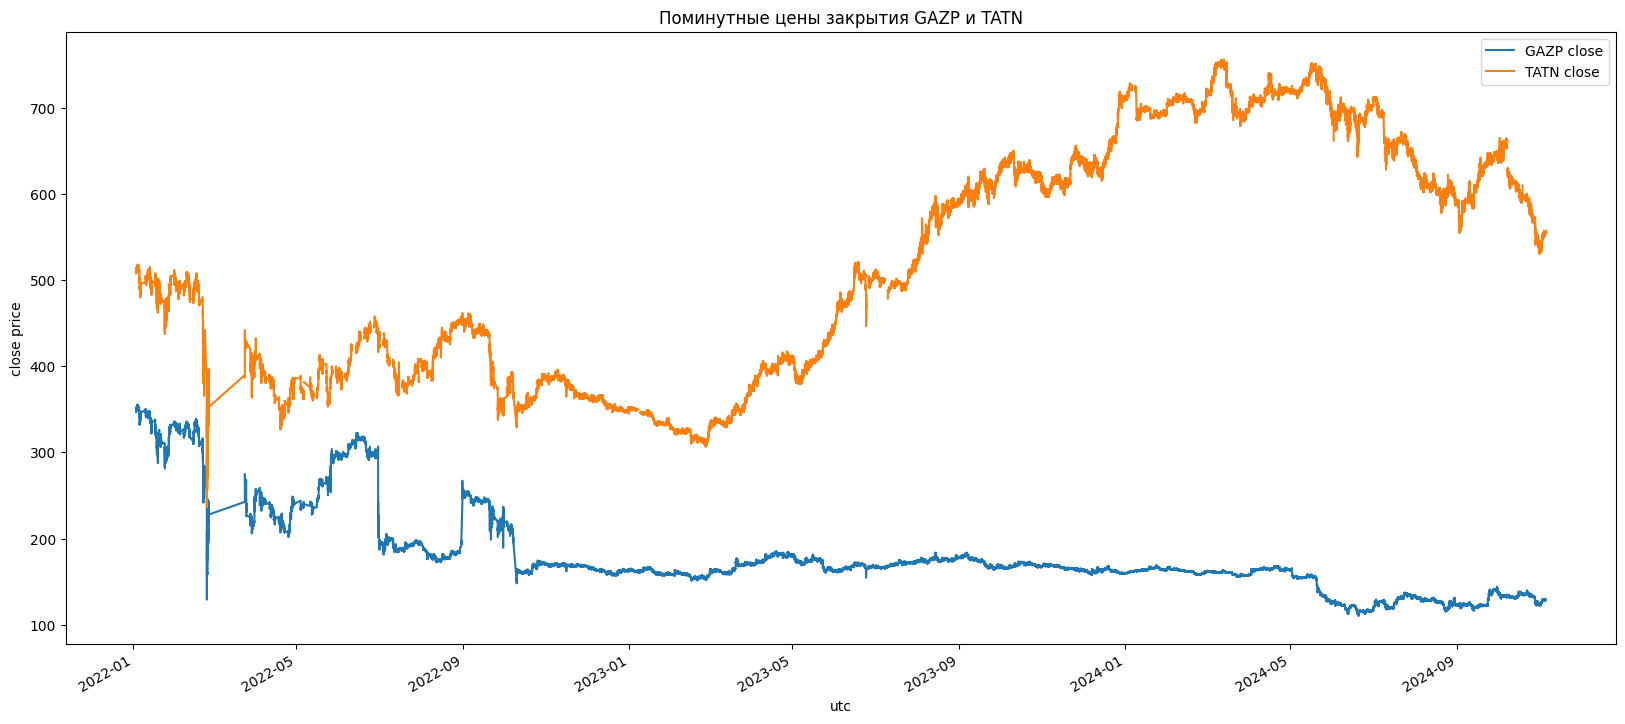

In [50]:
# tatn & gazp
pd.concat(dfs_per_instrument, axis=1)[['GAZP close', 'TATN close']].plot(figsize=(20, 9), ylabel='close price', title='Поминутные цены закрытия GAZP и TATN')

<Axes: xlabel='utc'>

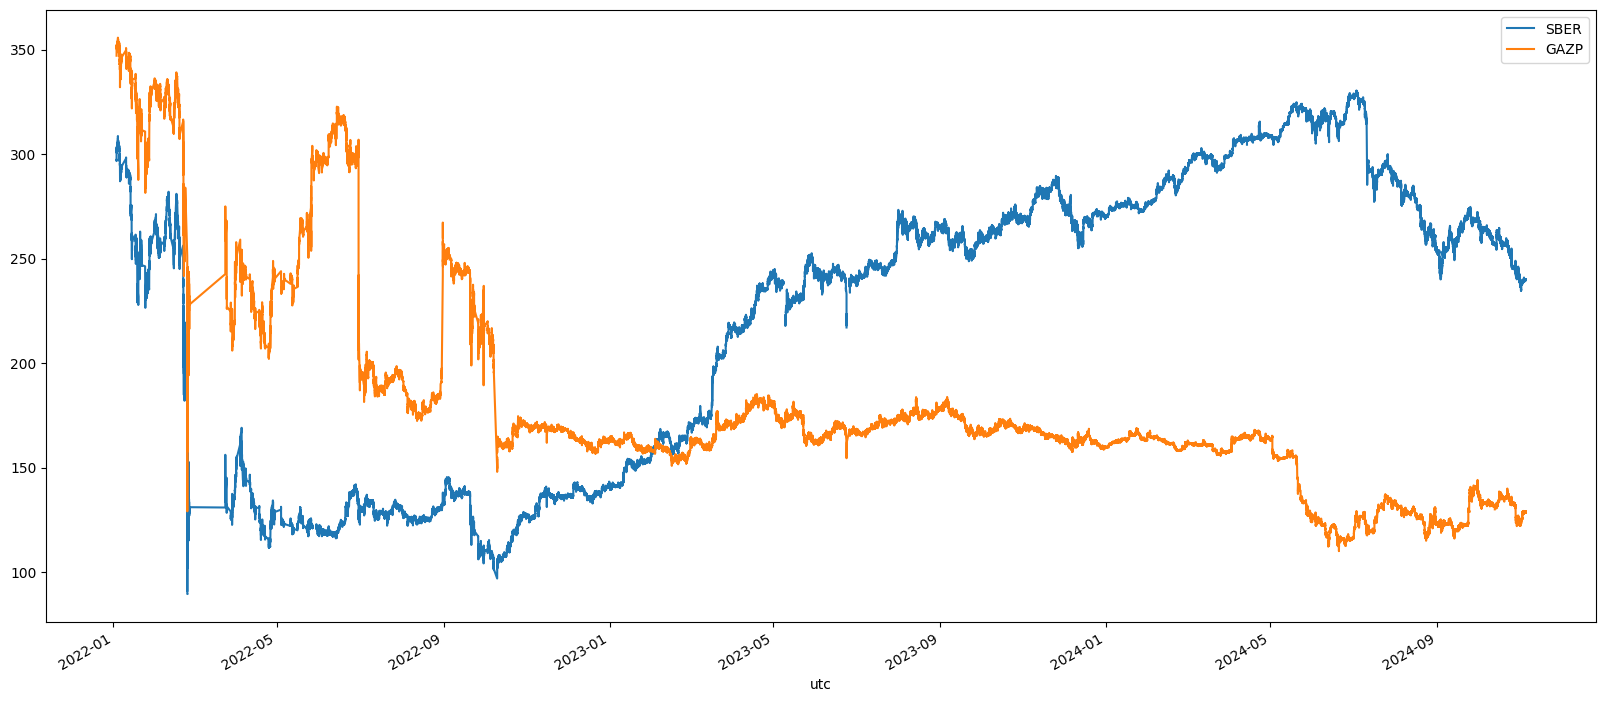

In [ ]:
# sber & gazp 2022-2024
pd.concat(dfs_per_instrument, axis=1).plot(figsize=(20, 9))

<Axes: xlabel='utc'>

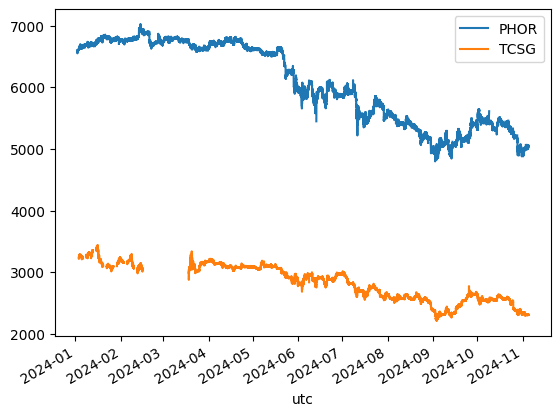

In [94]:
pd.concat(dfs_per_instrument, axis=1).plot()

<Axes: xlabel='utc'>

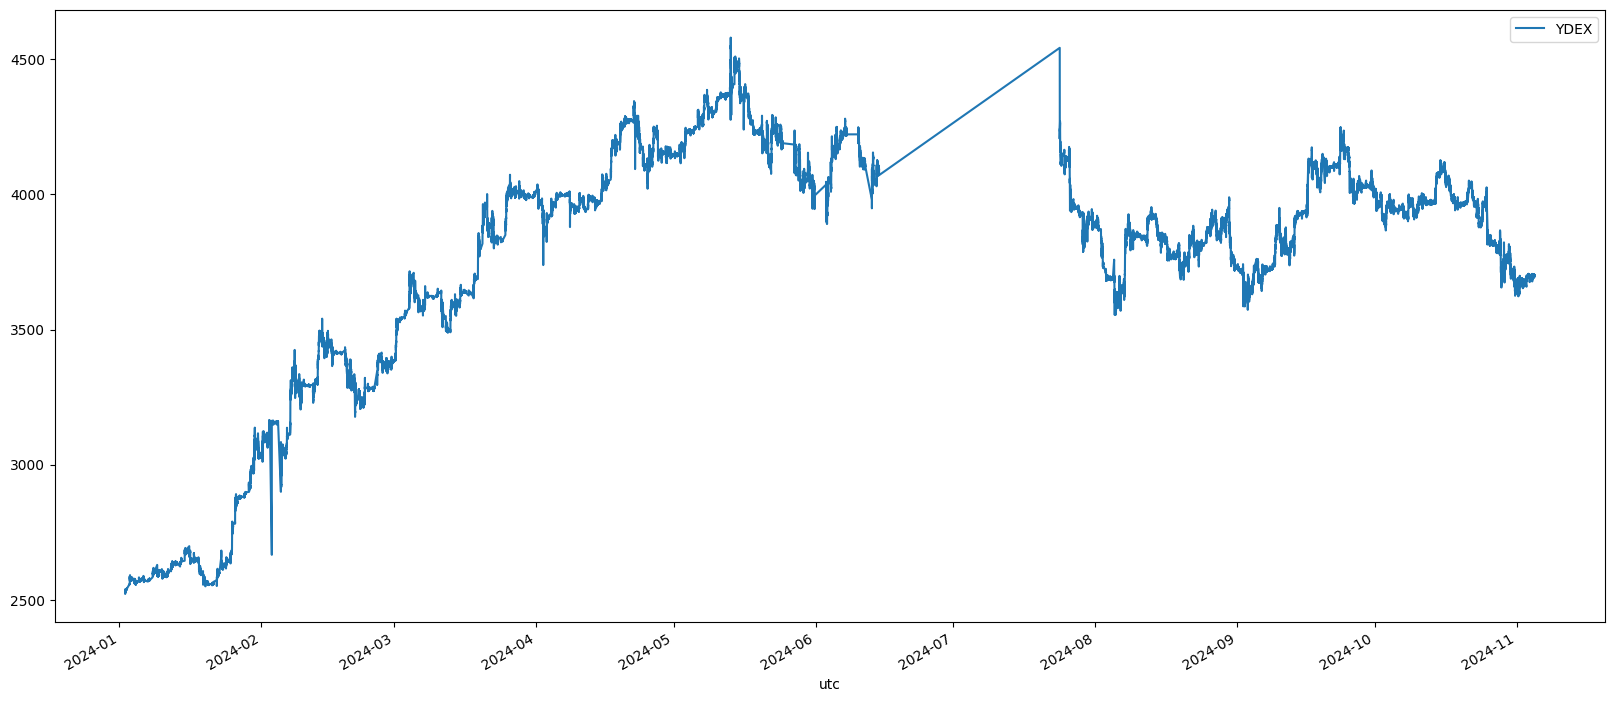

In [103]:
# plot yandex shares 2024:
pd.concat(dfs_per_instrument, axis=1).plot(figsize=(20, 9))

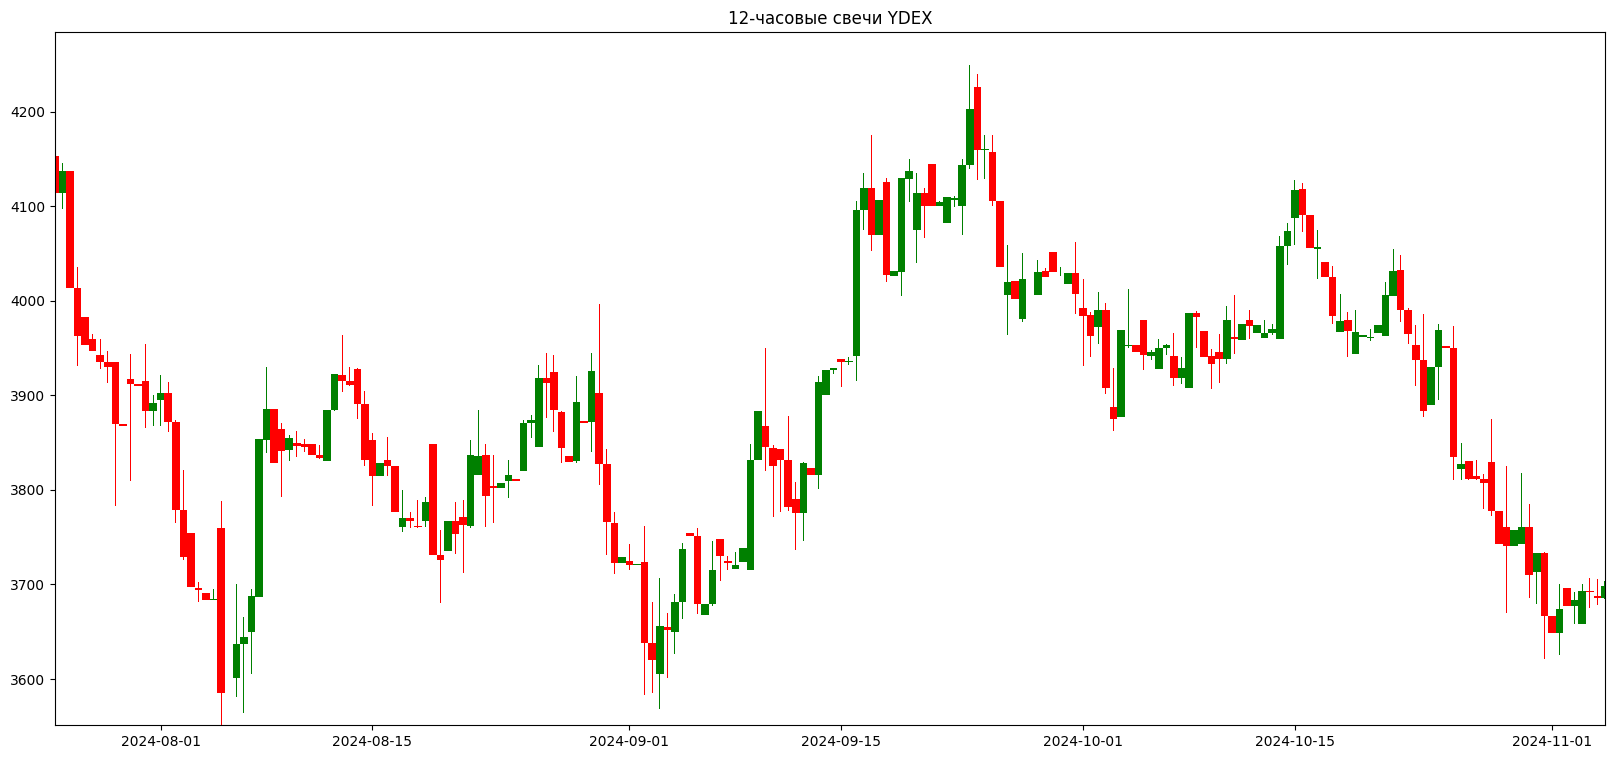

In [41]:
YDEX_day = dfs_per_instrument[0].loc['2024-07-25':].groupby(pd.Grouper(freq='12h')).agg({'YDEX open': 'first', 'YDEX close': 'last', 'YDEX high': 'max', 'YDEX low': 'min'})
up = YDEX_day[YDEX_day['YDEX close'] > YDEX_day['YDEX open']].dropna()
down = YDEX_day[YDEX_day['YDEX close'] < YDEX_day['YDEX open']].dropna()

plt.figure(figsize=(20, 9))

width = .5
width2 = .05

col_up = 'green'
col_down = 'red'

plt.bar(up.index, up['YDEX close']-up['YDEX open'], width, bottom=up['YDEX open'], color=col_up)
plt.bar(up.index, up['YDEX high']-up['YDEX low'], width2, bottom=up['YDEX low'], color=col_up) 


plt.bar(down.index, down['YDEX open']-down['YDEX close'], width, bottom=down['YDEX close'], color=col_down)
plt.bar(down.index, down['YDEX high']-down['YDEX low'], width2, bottom=down['YDEX low'], color=col_down) 

plt.xlim(YDEX_day.index[0], YDEX_day.index[-1])

plt.title("12-часовые свечи YDEX")

plt.show()